In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import datasets
import umap
from tqdm.notebook import tqdm as tq
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distances import wasserstein

In [2]:
import anchoring
from numba import njit,prange
from anchoring import get_approx_njit_ij,lrf

In [3]:
15*1797

26955

In [4]:
x = datasets.load_digits()['data']
im = datasets.load_digits()['images']
y = datasets.load_digits()['target']
ix = np.argsort(y)

x = x[ix]
im = im[ix]
y = y[ix]

nx=x.shape[0]
N=nx*(nx-1)//2
n_neighbors=15
N

1613706

In [5]:
Exact = np.load('exact_wasserstein.npz')['arr_0']


In [6]:
%timeit wasserstein(x[0],x[1])

224 µs ± 35 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:

start = time.time()
anchorBounder = anchoring.AnchorBounder(x,
                                        wasserstein,
                                        n_anchors=30,
                                        n_neighbors=15,
                                        min_prob=0.1,
                                        max_checks=300,
                                        random_seed=0,
                                        regression_sample_size=4000,
                                        splits=4)


anchorBounder.get_anchors()
print('get_anchors:', time.time()-start)

anchorBounder.get_approx()
print('get_approx:', time.time()-start)

anchorBounder.refine_approx()
print('refine_approx:', time.time()-start)

anchorBounder.refine_part_two()
print('refine_part_two:', time.time()-start)



get_anchors: 13.552888870239258
get_approx: 16.660996675491333
refine_approx: 33.72299289703369
refine_part_two: 34.403690814971924


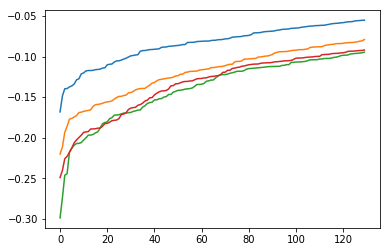

In [8]:
ab=anchorBounder
fig,ax = plt.subplots()
for h in ab.hs:
    ax.plot(h[:130])


In [9]:
anchorBounder.evals/N

0.1106930258671654

In [10]:
neighbors = anchorBounder.get_ann()
anchor_set = {i:set(neighbors[0][i]) for i in (range(anchorBounder.nx))}
exact_set = {i:set(np.argsort(Exact[i])[:anchorBounder.n_neighbors]) for i in (range(anchorBounder.nx))}

print(15*anchorBounder.nx-np.sum([(len(anchor_set[i].intersection(exact_set[i]))) for i in range(anchorBounder.nx)]))
    

111


In [25]:

start = time.time()
ab = anchoring.AnchorBounder(x,
                            wasserstein,
                            n_anchors=30,
                            n_neighbors=15,
                            min_prob=0.1,
                            max_checks=300,
                            random_seed=0,
                            regression_sample_size=4000,
                            splits=4,
                            locality=5)


ab.get_anchors()
print('get_anchors:', time.time()-start)

ab.get_LRApprox_lo_mem()
print('get_LRApprox_lo_mem:', time.time()-start)

A,B=ab.get_exact_lo_mem()
print('get_exact_lo_mem:', time.time()-start)


neighbors = A,B
anchor_set = {i:set(neighbors[0][i]) for i in (range(ab.nx))}
exact_set = {i:set(np.argsort(Exact[i])[:ab.n_neighbors]) for i in (range(ab.nx))}

print(15*ab.nx-np.sum([(len(anchor_set[i].intersection(exact_set[i]))) for i in range(ab.nx)]))
    

get_anchors: 11.211450099945068
get_LRApprox_lo_mem: 21.5401291847229
get_exact_lo_mem: 32.42900609970093
115


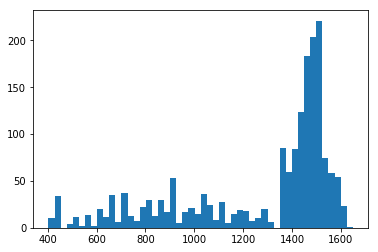

In [26]:
h = [len(ab.check[i]) for i in ab.check]
fig,ax = plt.subplots()
ax.hist(h,bins=50)
plt.show()

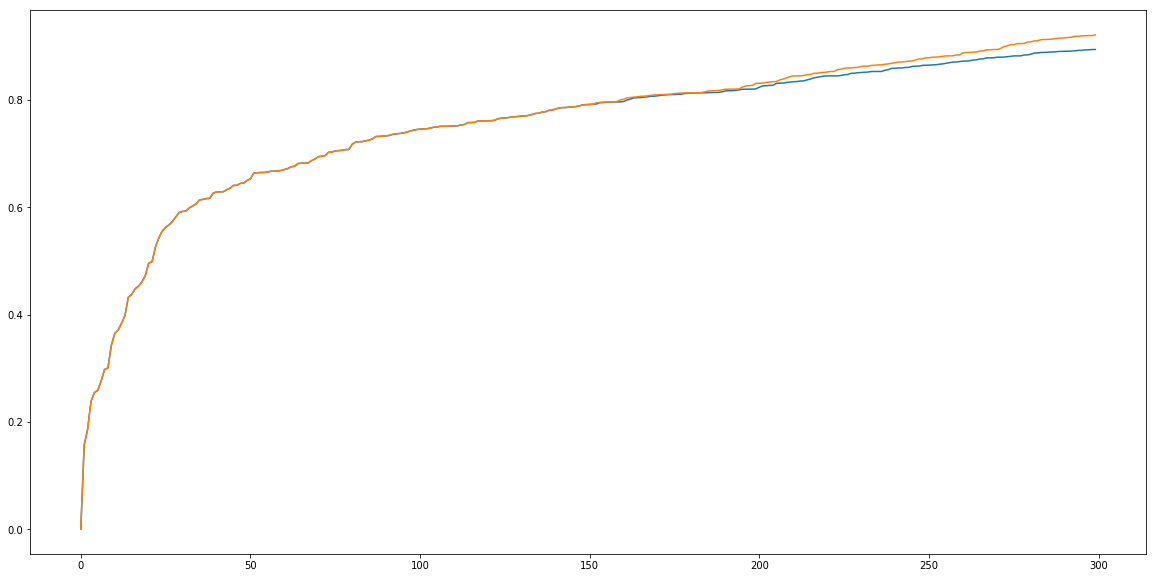

In [27]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(np.sort(anchorBounder.LRApprox[350])[:300])
ax.plot(ab.LRApprox[350][:300])